### Video link
https://youtu.be/kCc8FmEb1nY

# Initial comments before implementation

* The bigram model explanation
    * The meaning of __(B, T, C)__ - (*batch*, *time*, *channel*). **Batch** coordinate says at which batch are we. **Time** coordinate says at which position in the text are we. **Channel** says the index of the next characted, probab of which occurrence is encoded.

## The self attention math trick

In [2]:
import torch

In [11]:
torch.manual_seed(42)

A = torch.tril(torch.ones(3, 3))
print(f"{A=}\n")

A = A / torch.sum(A, 1, keepdim=True)
print(f"{A=}\n")


B = torch.randint(0, 10, (3, 2)).float()
print(f"{B=}\n")

print(f"C == {A @ B}")

A=tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

A=tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])

B=tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])

C == tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


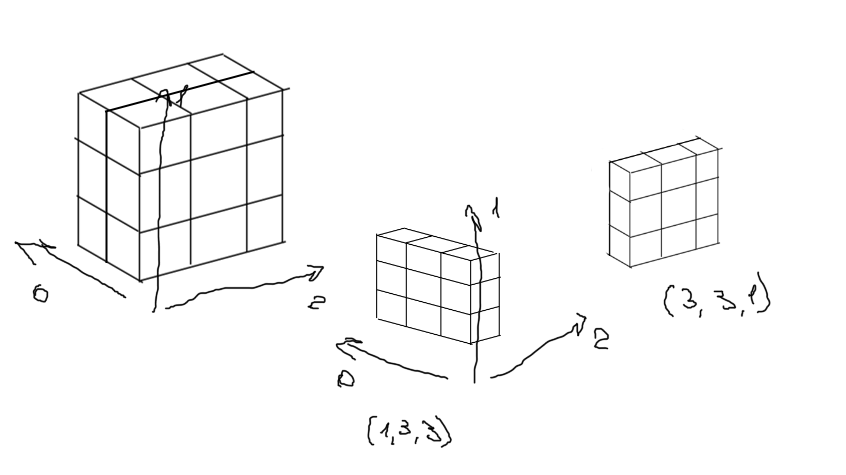

In [31]:
torch.manual_seed(42)
M = torch.randint(0, 10, (2, 2, 2)).float()
print(M[0])

B = torch.ones(2, 2) / 2

print(M @ B[None, ...])

print(M @ B)

print(M @ B[..., None])
print(M.shape, B[..., None].shape)

tensor([[2., 7.],
        [6., 4.]])
tensor([[[4.5000, 4.5000],
         [5.0000, 5.0000]],

        [[5.5000, 5.5000],
         [2.0000, 2.0000]]])
tensor([[[4.5000, 4.5000],
         [5.0000, 5.0000]],

        [[5.5000, 5.5000],
         [2.0000, 2.0000]]])
tensor([[[4.5000],
         [5.0000]],

        [[5.5000],
         [2.0000]]])
torch.Size([2, 2, 2]) torch.Size([2, 2, 1])


In [ ]:
torch.manual_seed(42)

A = torch.tril(torch.ones(3, 3))
print(f"{A=}\n")

A = A / torch.sum(A, 1, keepdim=True)
print(f"{A=}\n")

B = torch.randint(0, 10, (3, 2)).float()
print(f"{B=}\n")

print(f"C == {A @ B}")